# Import Libraries

In [1]:
import numpy as np
import pandas as pd 
import math
import os
import re
from Levenshtein import distance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import concurrent.futures
import warnings
warnings.filterwarnings('ignore')

# Load tables

In [2]:
# Change the current working directory to the CSV folder

def load_tables_from_csv(csv_folder_path ):
    """
    Load all the tables in in the input list

    Args:
    ----
    csv_folder_path: Path to folder where csv is stored
    input_table_list: List of tables from user

    Reutrns:
    ------
    tables_data: dictionary of loaded table dataframes
    NOTE: To access the table df later, use tables_data['tab_name'] Eg: tables_data['ekko']  
    """
    os.chdir(csv_folder_path)
    # Get the list of CSV files in the root directory
    csv_files = [filename for filename in os.listdir() if filename.endswith('.csv')]

    # # Dictionary to store DataFrames
    tables_data = {}

    # Load CSV files into DataFrames
    for csv_file in csv_files:
        table_name = os.path.splitext(csv_file)[0].upper()  # Assuming filenames are in uppercase
        df = pd.read_csv(csv_file  , encoding= 'unicode_escape'  , low_memory=False)
        if len(df.columns) > 50:
            first_50_columns = df.columns[:50] #only keeping 50 cols
            df = df[first_50_columns]
        tables_data[table_name.lower()] = [df]    
    return tables_data

In [3]:
csv_folder_path = r"D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\SAPDataset\ML_Training tables"
tables_data = load_tables_from_csv(csv_folder_path)

In [7]:
tables_data.keys()

dict_keys(['eban', 'ekko', 'likp', 'mkpf', 'rbkp', 'vbak', 'vbrk'])

In [15]:
tables_data['vbak'][0].columns

Index(['MANDT', 'VBELN', 'ERDAT', 'ERZET', 'ERNAM', 'ANGDT', 'BNDDT', 'AUDAT',
       'VBTYP'],
      dtype='object')

In [4]:
def import_dd03l():
    dd03l_ = pd.read_csv('D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\SAPDataset\DD03L.csv'  , encoding= 'unicode_escape', low_memory= False )
    
    tabnames_list = [ 'MKPF', 
                      'VBAK',   'VBRK', 
                      'LIKP', 
                    'EKKO',  'EBAN', 'RBKP', 'BKPF']
                    

# Filter the dd03l DataFrame based on the tabnames_list
    dd03l = dd03l_[dd03l_['TABNAME'].isin(tabnames_list)]
    del dd03l_
    return dd03l
dd03l = import_dd03l()

# Compute Mterics

## Datatype and permissible length

In [5]:
def get_col_datatyp_permissible_length_position_dictionary(tabname_str, tab_df):
    """
    Creates a dictionary with the datatype, permissible length, and position number for each column in the table.

    Args:
        tabname_str (str): Name of the SAP table.
        tab_df (pandas.DataFrame): DataFrame of the SAP table.
        dd03l (pandas.DataFrame): DataFrame containing metadata information.

    Returns:
        datatype_permissible_len_dict (dict): Dictionary with column name as key and [datatype, permissible len, position number] as value.
    """
    tabname_str = tabname_str.upper()
    datatype_permissible_len_dict = {}
    # position_counter = 1  #NOTE: change to DD03L position

    for col in tab_df.columns:
        col = col.upper()
        col_exists = dd03l['FIELDNAME'].eq(col).any()

        if col_exists:
            try:
                datatype = dd03l.loc[(dd03l['TABNAME'] == tabname_str) & (dd03l['FIELDNAME'] == col), 'DATATYPE'].iloc[0]
                max_len = dd03l.loc[(dd03l['TABNAME'] == tabname_str) & (dd03l['FIELDNAME'] == col), 'LENG'].iloc[0]
                col_position = dd03l.loc[(dd03l['TABNAME'] == tabname_str) & (dd03l['FIELDNAME'] == col), 'POSITION'].iloc[0]
                datatype_permissible_len_dict[col] = [datatype, max_len, col_position]
                # position_counter += 1  # Increment the counter for the next column
            except:
                datatype = "Datatype not found"
                max_len = "Permissible length not found"
                col_position = 'Not found'
                datatype_permissible_len_dict[col] = [datatype, max_len, col_position]
                # position_counter += 1

    return datatype_permissible_len_dict


## Uniquesness Score

In [6]:
def uniqueness_score(column):
    unique_values = column.unique()
    total_values = len(column)
    uniqueness_score = len(unique_values) / total_values
    return uniqueness_score

def calculate_uniqueness_scores(df):
    num_rows = len(df)
    num_groups = int(np.ceil(num_rows / 1000))
    groups = np.array_split(df.sample(frac=1), num_groups)
    uniqueness_df = pd.DataFrame(columns=df.columns)

    for group in groups:
        group_scores = []
        for col in df.columns:
            score = uniqueness_score(group[col])
            group_scores.append(score)
        uniqueness_df = uniqueness_df.append(pd.Series(group_scores, index=df.columns), ignore_index=True)
        

    return uniqueness_df

## Duplicate Values

In [7]:
def calculate_duplicate_metric(uniqueness_df):
    duplicate_df = 1 - uniqueness_df
    return duplicate_df

## Richness

In [8]:
def calculate_richness_score(duplicate_metric_df):
    richness_df = 1 / duplicate_metric_df
    richness_df = richness_df.replace([np.inf, -np.inf], 10000) #replace inf values with large number
    return richness_df

## Similarity Score

In [9]:
def similarity_score(column):
    distinct_values = column.unique()
    num_distinct = len(distinct_values)
    similarity_scores = []

    if num_distinct <= 1:
        return 0.0  # Return 0 for columns with only one unique value


    for i in range(num_distinct):
        for j in range(i + 1, num_distinct):
            distance_normalized = distance(str(distinct_values[i]), str(distinct_values[j])) / max(len(str(distinct_values[i])), len(str(distinct_values[j])))
            similarity_scores.append(1 - distance_normalized)

    return np.min(similarity_scores)  # Compute the average similarity score

def calculate_similarity_scores(df):
    num_rows = len(df)
    num_groups = int(np.ceil(num_rows / 1000))
    groups = np.array_split(df.sample(frac=1), num_groups)
    similarity_scores_list = []

    for group in groups:
           group_scores = []
           for col in df.columns:
               score = similarity_score(group[col])
               group_scores.append(score)
           similarity_scores_list.append(group_scores)

    # similarity_df = pd.DataFrame(similarity_scores_list, columns=[f"{col}_similarity" for col in df.columns])
    similarity_df = pd.DataFrame(similarity_scores_list, columns=[col for col in df.columns])
    similarity_df = similarity_df.replace([np.nan, -np.nan], 0)
    similarity_df = similarity_df.replace([np.inf, -np.inf], 10000)
    return similarity_df


## Missing Values

In [10]:
def missing_value_ratio(df):
    """
    Computes the ratio of missing values in subsets of 1000 random rows for each column of the given DataFrame
    
    Args:
        df (pandas.DataFrame): Input DataFrame
        
    Returns:
        pandas.DataFrame: A DataFrame containing the missing value ratio for each column
    """
    missing_values = [np.nan, None, " ", 0]  # Define the set of missing values
    subset_size = 1000  # Define the size of each subset
    
    # Compute the number of subsets needed for each column
    num_subsets = (df.shape[0] + subset_size - 1) // subset_size
    
    # Initialize an empty DataFrame to store the results
    missing_value_df = pd.DataFrame(columns=df.columns)
    
    # Compute the missing value ratio for each subset of 1000 rows for each column
    for i in range(num_subsets):
        start = i * subset_size
        end = min((i + 1) * subset_size, df.shape[0])
        subset = df.iloc[start:end]
        missing_count = subset.apply(lambda x: x.isin(missing_values).sum())
        missing_ratio = missing_count / subset_size
        missing_value_df.loc[i] = missing_ratio
    
    return missing_value_df

## Formatting constraints

In [11]:
def calculate_formatting_constraints(missing_value_df):
    """
    Calculates the formatting constraints metric as 1 - missing value ratio for each column of the given DataFrame
    
    Args:
        df (pandas.DataFrame): Input DataFrame
        
    Returns:
        pandas.DataFrame: A DataFrame containing the formatting constraints metric for each column
    """
    formatting_constraints_df = 1 - missing_value_df
    return formatting_constraints_df

## Entropy

In [12]:
def entropy_formula(column):
    counts = column.value_counts(normalize=True)
    entropy = 0
    for count in counts:
        entropy -= count * math.log(count, 2)
    return entropy

def calculate_entropy(df):
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)
    entropy_scores = {}  # dictionary to store entropy scores for each column

    for column in df.columns:
        entropy_scores[column] = []  # initialize list for column's entropy scores
        for i in range(math.ceil(len(df) / 1000)):  # loop through subsets of 1000 random rows
            subset = df[column].sample(n=1000)  # select 1000 random rows for the column
            entropy = entropy_formula(subset)
            entropy_scores[column].append(entropy)

    entropy_df = pd.DataFrame.from_dict(entropy_scores)
    return entropy_df

## Combined df of metrics with col names

In [13]:
def combine_metrics( dataTyp_len_position , uniqueness_df , duplicate_metrics_df ,
                                calculate_richness_df , similarity_score_df , missing_value_df ,
                                formatting_constraints_df , entropy_df , tab_name_str , table_df):
    # initialize an empty DataFrame to store the results
    tab_name_str = tab_name_str.upper()
    result_df = pd.DataFrame(columns=['table_name', 'col_name',
                                      'uniqueness_scores','duplicate_values','richness',
                                      'similarity_score', 'missing_ratio','formatting_constraints',
                                      'entropy','time_precision', 'value_ambiguity','position' , 
                                      'permissible_len' , 'datatype'])
    dataTyp_len_position_dict = dataTyp_len_position
    # iterate over the columns and fill the result_df
    for col_name in table_df.columns:
        # get the values for the current column from each input DataFrame
        unique_vals = uniqueness_df[col_name]
        duplicate_values = duplicate_metrics_df[col_name]
        richness = calculate_richness_df[col_name]
        similarity_score = similarity_score_df[col_name]
        miss_vals = missing_value_df[col_name]
        formatting_constraints = formatting_constraints_df[col_name]
        ent_vals = entropy_df[col_name]
        
         # Extract information from dataTyp_len_position_dict for the current column
        col_info = dataTyp_len_position_dict.get(col_name, [None, None, None])
        data_type, permissible_len, position = col_info

        # Determine time_precision and value_ambiguity based on conditions
        time_precision = 1 if data_type in ['DATS', 'TIMS'] else 0
        value_ambiguity = 1 if col_name == 'tcode' else 0

        # combine the values into a single Series
        combined_vals  = pd.DataFrame({ 'table_name': tab_name_str,
                                        'col_name': col_name,
                                        'uniqueness_scores': unique_vals,
                                        'duplicate_values': duplicate_values,
                                        'richness': richness,
                                        'similarity_score': similarity_score,
                                        'missing_ratio': miss_vals,
                                        'formatting_constraints': formatting_constraints,
                                        'entropy': ent_vals,
                                        'time_precision': time_precision,
                                        'value_ambiguity': value_ambiguity,
                                        'position': position,
                                        'permissible_len': permissible_len,
                                        'datatype': data_type
                                        })
        result_df = pd.concat([result_df , combined_vals])

    # generate the list of target values
    # targets = [select_conditions[col_names.index(col_name)] for col_name in result_df['col_name']]

    # assign the list to a new column in result_df
    # result_df['targets'] = targets
    return result_df

# Single function to compute metrics

In [14]:
# generate the df for all these metrics as below for the table
# 

In [14]:
def ComputeMetrics(tab_name_str , table_df):
    # Modifying this function to nnot give col select conditions as it will be an unsupervised training set. 
    #calculate the individual metrics first
    dataTyp_len_position =          get_col_datatyp_permissible_length_position_dictionary(tab_name_str , table_df)
    uniqueness_df =                 calculate_uniqueness_scores(table_df)
    duplicate_metrics_df =          calculate_duplicate_metric(uniqueness_df)
    calculate_richness_df =         calculate_richness_score(duplicate_metrics_df)
    similarity_score_df =           calculate_similarity_scores(table_df)
    missing_value_df =              missing_value_ratio(table_df)
    formatting_constraints_df =     calculate_formatting_constraints(missing_value_df)
    entropy_df =                    calculate_entropy(table_df)

    #combine all the metrics to comput the training df
    result_df = combine_metrics( dataTyp_len_position , uniqueness_df , duplicate_metrics_df ,
                                            calculate_richness_df , similarity_score_df , missing_value_df ,
                                            formatting_constraints_df , entropy_df , tab_name_str , table_df)
    return result_df

# Compute features

In [15]:
def compute_features(result):
    weights = {
    'Completeness': {'uniqueness_scores': 0.5, 'missing_ratio': 0.5},
    'Precision':    {'permissible_len': 0.33 , 'missing_ratio': 0.33 , 'time_precision': 0.33 },  
    'Integrity':    {'duplicate_values': 0.5,'formatting_constraints': 0.5 }, 
    'Objectivity':  {'uniqueness_scores': 0.5 , 'entropy':0.5 },  
    'Conciseness':  {'similarity_score': 0.5 , 'value_ambiguity':0.5 },    
    'Uniqueness':   {'uniqueness_scores': 0.7 ,'duplicate_values': 0.1,'richness':0.1,'similarity_score': 0.1 },
    'Informativeness': {'entropy':0.2 , 'position':0.2 ,'richness':0.2 ,'time_precision':0.2,'value_ambiguity':0.2 }  
    }

    # Initialize an empty DataFrame to store the calculated features
    output_df = pd.DataFrame(columns= list(weights.keys()))
    output_df[['table_name', 'col_name', 'datatype']] = result[['table_name', 'col_name', 'datatype']]
    # Initialize empty lists to store table_name, col_name, and datatype

    # Calculate features for each metric
    for feature, metrics in weights.items():
        feature_values = []

        for index, row in result.iterrows():
            value = 0.0

            for metric, weight in metrics.items():
                value += weight * row.get(metric, 0.0)

            feature_values.append(value)

        output_df[feature] = feature_values

    feature_df = output_df
    return feature_df
    # Define the weights for each metric


In [20]:
def build_training_features(tables_data):  
    final_features = pd.DataFrame()
    final_metrics_df = pd.DataFrame()
    for table_name in list(tables_data.keys()):
        print('Computing for:' , table_name)
        table_name_ = table_name.upper()
        metrics_df = ComputeMetrics(table_name_ , tables_data[table_name][0])
        feature_df =  compute_features(metrics_df)
        if final_features.empty:
            final_metrics_df = metrics_df
            final_features = feature_df
        else:
            final_metrics_df = pd.concat([final_metrics_df , metrics_df], axis=0, ignore_index= True)
            final_features = pd.concat([final_features , feature_df], axis=0, ignore_index= True) 
    return final_features , final_metrics_df

In [21]:
final_features , final_metrics_df = build_training_features(tables_data)

Computing for: eban
Computing for: ekko
Computing for: likp
Computing for: mkpf
Computing for: rbkp
Computing for: vbak
Computing for: vbrk


In [16]:
#Sampling bkpf separately as it is too heavy to use whole table.
bkpf = pd.read_csv(r'D:\OneDrive - Students RWTH Aachen University\PADS thesis topic\SAPDataset\P2P\BKPF.csv',encoding= 'unicode_escape'  , low_memory=False)
# selecting 30k random rows of bkpf to compute metrics
bkpf = bkpf.sample(n=30000)
first_50_columns_bkpf = bkpf.columns[:50] #only keeping 50 cols
bkpf = bkpf[first_50_columns_bkpf]

In [17]:
bkpf.columns

Index(['MANDT', 'BUKRS', 'BELNR', 'GJAHR', 'BLART', 'BLDAT', 'BUDAT', 'MONAT',
       'CPUDT', 'CPUTM', 'AEDAT', 'UPDDT', 'WWERT', 'USNAM', 'TCODE', 'BVORG',
       'XBLNR', 'DBBLG', 'STBLG', 'STJAH', 'BKTXT', 'WAERS', 'KURSF', 'KZWRS',
       'KZKRS', 'BSTAT', 'XNETB', 'FRATH', 'XRUEB', 'GLVOR', 'GRPID', 'DOKID',
       'ARCID', 'IBLAR', 'AWTYP', 'AWKEY', 'FIKRS', 'HWAER', 'HWAE2', 'HWAE3',
       'KURS2', 'KURS3', 'BASW2', 'BASW3', 'UMRD2', 'UMRD3', 'XSTOV', 'STODT',
       'XMWST', 'CURT2'],
      dtype='object')

In [52]:
# computing features for bkpf
metrics_df_bkpf = ComputeMetrics('BKPF' , bkpf)
feature_df_bkpf =  compute_features(metrics_df_bkpf)

In [60]:
# adding bkpf features to main features array
final_metrics_df = pd.concat([final_metrics_df , metrics_df_bkpf], axis=0, ignore_index= True)
final_features = pd.concat([final_features , feature_df_bkpf], axis=0, ignore_index= True)

# Data Analysis

<AxesSubplot:>

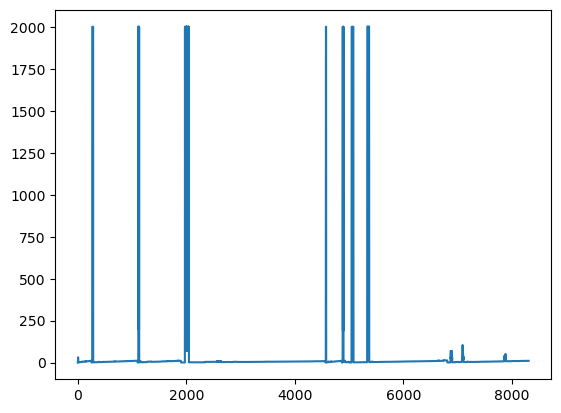

In [68]:
final_features['Informativeness'].plot()

In [69]:
final_features.to_csv('final_features_03092023_2222.csv' , index = False)
final_metrics_df.to_csv('final_metrics_03092023_2222.csv', index = False)

In [70]:
final_features.isnull().sum().any() #check for NaN in whole DF

False

In [71]:
final_features.head()

,Completeness,Precision,Integrity,Objectivity,Conciseness,Uniqueness,Informativeness,table_name,col_name,datatype
0,0.005887,0.99198,0.994113,0.094149,0.166667,0.237378,0.437666,EBAN,MANDT,CLNT
1,0.002309,0.99000,0.997691,0.086561,0.000000,0.203235,0.434629,EBAN,MANDT,CLNT
2,0.001734,0.99000,0.998266,0.100380,0.000000,0.202429,0.440154,EBAN,MANDT,CLNT
3,0.002312,0.99000,0.997688,0.102161,0.000000,0.203239,0.440869,EBAN,MANDT,CLNT
4,0.002312,0.99000,0.997688,0.090962,0.000000,0.203239,0.436389,EBAN,MANDT,CLNT


# Gaussian Mixture model

In [86]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

In [92]:
final_features_GMM = final_features.copy()

In [73]:
X = final_features.drop(['table_name', 'col_name', 'datatype'], axis=1)
X.head()

,Completeness,Precision,Integrity,Objectivity,Conciseness,Uniqueness,Informativeness
0,0.005887,0.99198,0.994113,0.094149,0.166667,0.237378,0.437666
1,0.002309,0.99000,0.997691,0.086561,0.000000,0.203235,0.434629
2,0.001734,0.99000,0.998266,0.100380,0.000000,0.202429,0.440154
3,0.002312,0.99000,0.997688,0.102161,0.000000,0.203239,0.440869
4,0.002312,0.99000,0.997688,0.090962,0.000000,0.203239,0.436389


In [87]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the DataFrame
X_normalised = scaler.fit_transform(X)

# Create a new DataFrame with the normalized data
X_normalised = pd.DataFrame(X_normalised, columns=X.columns)

X_normalised.head()

,Completeness,Precision,Integrity,Objectivity,Conciseness,Uniqueness,Informativeness
0,0.006879,0.05015,0.993121,0.017082,0.5,0.000037,0.000019
1,0.002311,0.05000,0.997689,0.015698,0.0,0.000003,0.000017
2,0.001576,0.05000,0.998424,0.018218,0.0,0.000002,0.000020
3,0.002314,0.05000,0.997686,0.018543,0.0,0.000003,0.000020
4,0.002314,0.05000,0.997686,0.016500,0.0,0.000003,0.000018


In [99]:
# Create a GMM model with the chosen number of components
gmm = GaussianMixture(n_components=4)

# Fit the model to your data
gmm.fit(X_normalised)

GaussianMixture(n_components=4)

In [98]:
del(gmm)

In [100]:
gmm.means_

array([[6.38589654e-01, 2.12812785e-01, 3.61410346e-01, 5.05364381e-04,
        0.00000000e+00, 2.39468159e-07, 2.85437500e-03],
       [1.70154120e-01, 1.17230660e-01, 8.29845880e-01, 7.62655016e-02,
        5.06687724e-01, 3.79489204e-05, 1.27739702e-03],
       [6.36363771e-01, 2.42736092e-01, 3.63636229e-01, 9.98825184e-01,
        1.78247219e-01, 5.09180599e-01, 5.09579268e-01],
       [2.66386580e-01, 1.61770342e-01, 7.33613420e-01, 2.59482005e-01,
        0.00000000e+00, 1.46173777e-04, 2.44837962e-03]])

In [75]:
gmm.means_

array([[2.91443772e-01, 2.63975124e+00, 7.08556228e-01, 8.25929471e-01,
        1.21696455e-02, 2.59521351e-01, 5.33057690e+00],
       [5.00006897e-01, 3.30000455e+00, 4.99993103e-01, 5.48268954e+00,
        7.42911877e-02, 1.00071486e+03, 2.00279032e+03],
       [4.99490023e-01, 3.30000000e+00, 5.00509977e-01, 5.48181460e+00,
        6.38513514e-02, 9.87851313e+01, 1.98538876e+02],
       [4.77053141e-01, 3.00572573e+00, 5.22946859e-01, 5.40753993e+00,
        1.69847321e-02, 9.14334424e+00, 2.22587254e+01]])

In [37]:
component_params = []
for i in range(4):
    mean = gmm.means_[i][0]
    std_dev = np.sqrt(gmm.covariances_[i][0][0])
    component_params.append((mean, std_dev))

In [38]:
component_params

[(0.26055087787043935, 0.1922255890843493),
 (0.5000068965517241, 0.0010034186510616864),
 (0.49871744937424445, 0.0024865166157250654),
 (0.32415907576740144, 0.22412902206322108)]

In [101]:
cluster_assignments = gmm.predict(X)
final_features_GMM['Cluster'] = cluster_assignments

In [102]:
final_features_GMM

,Completeness,Precision,Integrity,Objectivity,Conciseness,Uniqueness,Informativeness,table_name,col_name,datatype,Cluster
0,0.005887,0.99198,0.994113,0.094149,0.166667,0.237378,0.437666,EBAN,MANDT,CLNT,1
1,0.002309,0.99000,0.997691,0.086561,0.000000,0.203235,0.434629,EBAN,MANDT,CLNT,3
2,0.001734,0.99000,0.998266,0.100380,0.000000,0.202429,0.440154,EBAN,MANDT,CLNT,3
3,0.002312,0.99000,0.997688,0.102161,0.000000,0.203239,0.440869,EBAN,MANDT,CLNT,3
4,0.002312,0.99000,0.997688,0.090962,0.000000,0.203239,0.436389,EBAN,MANDT,CLNT,3
...,...,...,...,...,...,...,...,...,...,...,...
8303,0.001000,0.66000,0.999000,0.001000,0.000000,0.201400,10.200401,BKPF,CURT2,CHAR,3
8304,0.002500,0.66099,0.997500,0.015732,0.000000,0.201400,10.206294,BKPF,CURT2,CHAR,3
8305,0.002000,0.66066,0.998000,0.019811,0.000000,0.201400,10.207925,BKPF,CURT2,CHAR,3
8306,0.001500,0.66033,0.998500,0.011407,0.000000,0.201400,10.204564,BKPF,CURT2,CHAR,3


In [85]:
np.unique(final_features_GMM['table_name'] , return_counts= True)

(array(['BKPF', 'EBAN', 'EKKO', 'LIKP', 'MKPF', 'RBKP', 'VBAK', 'VBRK'],
       dtype=object),
 array([1500,  250,  850,  800, 2664,  300,  144, 1800], dtype=int64))

In [103]:
np.unique(final_features_GMM['Cluster'] , return_counts= True)

(array([1, 2, 3], dtype=int64), array([ 130,  639, 7539], dtype=int64))

In [78]:
np.unique(final_features_GMM['Cluster'] , return_counts= True)

(array([0, 1, 2, 3], dtype=int64),
 array([7864,  145,   37,  262], dtype=int64))

In [44]:
tables_data['rbkp'][0]

,MANDT,BELNR,GJAHR,BLART,BLDAT,BUDAT,USNAM,TCODE,CPUDT,CPUTM,...,REPART,RBSTAT,KNUMVE,KNUMVL,ARKUEN,ARKUEMW,MAKZN,MAKZMW,LIEFFN,LIEFFMW
0,800,5105609642,2022,RE,20221001,20220901,HKARIMI,MIRO,20221001,2914,...,,5,,,0,0,0,0,0,0
1,800,5105609643,2022,RE,20220927,20220927,HKARIMI,MIRO,20221001,50439,...,,5,,,0,0,0,0,0,0
2,800,5105609644,2022,RE,20220831,20220831,HKARIMI,MIRO,20221001,225635,...,,5,,,0,0,0,0,0,0
3,800,5105609645,2022,RE,20220927,20220802,HKARIMI,MIRO,20221002,64925,...,,5,,,0,0,0,0,0,0
4,800,5105609646,2022,RE,20221003,20220908,HKARIMI,MIRO,20221003,23731,...,,5,,,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,800,5800000030,2008,KP,20080103,20080103,ZECHA,MR11,20080103,131357,...,,5,,,0,0,0,0,0,0
5725,810,3,1995,RN,19950622,19950622,DUENGELHOEF,MR1M,19950622,172114,...,,,,,0,0,0,0,0,0
5726,810,4,1995,RN,19950622,19950622,DUENGELHOEF,MR1M,19950622,174659,...,,,,,0,0,0,0,0,0
5727,810,5,1995,RN,19950703,19950703,DUENGELHOEF,MR1M,19950703,162015,...,,,,,0,0,0,0,0,0


In [46]:
tables_data.keys()

dict_keys(['eban', 'ekko', 'likp', 'mkpf', 'rbkp', 'vbak', 'vbrk'])

In [45]:
tables_to_consider = ['MKPF' , 'LIKP' , 'VBAK' , 'LTAK' , 'EKKO' , 'MKPF' , 'RBKP' , 'BKPF' , 'EBAN' ,
                      'VBAK' , 'LIKP' , 'VBRK' , 'VBRK']

tables_to_consider = set(tables_to_consider)
tables_to_consider

{'BKPF', 'EBAN', 'EKKO', 'LIKP', 'LTAK', 'MKPF', 'RBKP', 'VBAK', 'VBRK'}